In [1]:
import configparser

# v20 OANDA API - 3rd party
import json
from oandapyV20 import API    # the client
import oandapyV20.endpoints.trades as trades

config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [2]:
import pandas as pd
import datetime
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments

# The v20 api handles from times a little differently - be careful of the timezone
params={"from": parser.parse("2016-12-07 18:00:00 EDT").strftime('%s'),
        "to": parser.parse("2016-12-10 00:000:00 EDT").strftime('%s'),
        "granularity":'M1',
        "price":'A'}
r = instruments.InstrumentsCandles(instrument="EUR_USD",params=params)
data = client.request(r)
results= [{"time":x['time'],"closeAsk":float(x['ask']['c'])} for x in data['candles']]
df = pd.DataFrame(results).set_index('time')

df.index = pd.DatetimeIndex(df.index)

df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2702 entries, 2016-12-07 23:00:00 to 2016-12-09 21:59:00
Data columns (total 1 columns):
closeAsk    2702 non-null float64
dtypes: float64(1)
memory usage: 42.2 KB


In [3]:
import numpy as np

df['returns'] = np.log(df['closeAsk'] / df['closeAsk'].shift(1))

cols = []

for momentum in [15, 30, 60, 120]:
    col = 'position_%s' % momentum
    df[col] = np.sign(df['returns'].rolling(momentum).mean())
    cols.append(col)

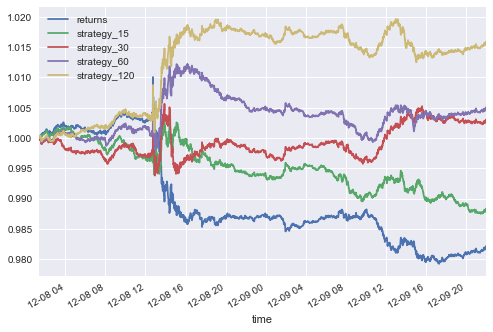

In [4]:
%matplotlib inline
import seaborn as sns; sns.set()

strats = ['returns']

for col in cols:
    strat = 'strategy_%s' % col.split('_')[1] 
    df[strat] = df[col].shift(1) * df['returns']
    strats.append(strat)

df[strats].dropna().cumsum().apply(np.exp).plot()

In [6]:
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oandapyV20.exceptions import V20Error, StreamTerminated
        
class MomentumTrader(PricingStream): 
    def __init__(self, momentum, *args, **kwargs): 
        PricingStream.__init__(self, *args, **kwargs)
        self.ticks = 0 
        self.position = 0
        self.df = pd.DataFrame()
        self.momentum = momentum
        self.units = 100000
        self.connected = False
        self.client = API(access_token=config['oanda']['access_token'])
    def create_order(self, units):
        order = orders.OrderCreate(accountID=config['oanda']['account_id'], data=MarketOrderRequest(instrument="EUR_USD", units=units).data)
        response = self.client.request(order)
        print('\t', response)
    def on_success(self, data):
        self.ticks += 1
        print("ticks=",self.ticks)
        # print(self.ticks, end=', ')
        # appends the new tick data to the DataFrame object
        self.df = self.df.append(pd.DataFrame([{'time': data['time'],'closeoutAsk':data['closeoutAsk']}],
                                 index=[data["time"]]))
        # transforms the time information to a DatetimeIndex object
        self.df.index = pd.DatetimeIndex(self.df["time"])
        
        # Convert items back to numeric (Why, OANDA, why are you returning strings?)
        self.df['closeoutAsk'] = pd.to_numeric(self.df["closeoutAsk"],errors='ignore')
        # resamples the data set to a new, homogeneous interval
        dfr = self.df.resample('5s').last().bfill()
        # calculates the log returns
        dfr['returns'] = np.log(dfr['closeoutAsk'] / dfr['closeoutAsk'].shift(1))        
        # derives the positioning according to the momentum strategy
        dfr['position'] = np.sign(dfr['returns'].rolling( 
                                      self.momentum).mean())
        print("position=",dfr['position'].ix[-1])
        if dfr['position'].ix[-1] == 1:
            print("go long")
            if self.position == 0:
                self.create_order(self.units)
            elif self.position == -1:
                self.create_order(self.units * 2)
            self.position = 1
        elif dfr['position'].ix[-1] == -1:
            print("go short")
            if self.position == 0:
                self.create_order(-self.units)
            elif self.position == 1:
                self.create_order(-self.units * 2)
            self.position = -1
        if self.ticks == 25000:
            print("close out the position")
            if self.position == 1:
                self.create_order(-self.units)
            elif self.position == -1:
                self.create_order(self.units)
            self.disconnect()
    def disconnect(self):
        self.connected=False
    def rates(self, account_id, instruments, **params):
        self.connected = True
        params = params or {}
        ignore_heartbeat = None
        if "ignore_heartbeat" in params:
            ignore_heartbeat = params['ignore_heartbeat']
        while self.connected:
            response = self.client.request(self)
            for tick in response:
                if not self.connected:
                    break
                if not (ignore_heartbeat and tick["type"]=="HEARTBEAT"):
                    print(tick)
                    self.on_success(tick)


In [11]:
# Set momentum to be the number of previous 5 second intervals to calculate against
# For two hours, momentum = 120 * 5 = 600
# I am using momentum = 6 to speed things up (but it is a terrible prediction!)
mt = MomentumTrader(momentum=6,accountID=config['oanda']['account_id'],params={"instruments": "EUR_USD"})

In [12]:
mt.rates(account_id=config['oanda']['account_id'], instruments="EUR_USD", ignore_heartbeat=True)

{'type': 'PRICE', 'time': '2017-03-07T02:33:45.528790510Z', 'bids': [{'price': '1.05836', 'liquidity': 10000000.0}, {'price': '1.05834', 'liquidity': 10000000.0}], 'asks': [{'price': '1.05849', 'liquidity': 10000000.0}, {'price': '1.05851', 'liquidity': 10000000.0}], 'closeoutBid': '1.05832', 'closeoutAsk': '1.05853', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 1
position= nan
{'type': 'PRICE', 'time': '2017-03-07T02:34:31.539294195Z', 'bids': [{'price': '1.05832', 'liquidity': 10000000.0}, {'price': '1.05830', 'liquidity': 10000000.0}], 'asks': [{'price': '1.05845', 'liquidity': 10000000.0}, {'price': '1.05847', 'liquidity': 10000000.0}], 'closeoutBid': '1.05828', 'closeoutAsk': '1.05849', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 2
position= 0.0
{'type': 'PRICE', 'time': '2017-03-07T02:34:49.416958320Z', 'bids': [{'price': '1.05833', 'liquidity': 10000000.0}, {'price': '1.05831', 'liquidity': 10000000.0}], 'asks': [{'price

KeyboardInterrupt: 